[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyo-takano/efficientcube/blob/main/notebooks/15_Puzzle.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/kyo-takano/efficientcube/blob/main/notebooks/15_Puzzle.ipynb)

# EfficientCube: 15 Puzzle

[![TMLR](https://img.shields.io/badge/TMLR_1188-112467?style=for-the-badge)](https://openreview.net/forum?id=bnBeNFB27b)
[![GitHub Repository](https://img.shields.io/badge/-Repository-2dba4e?logo=github&style=for-the-badge)](https://github.com/kyo-takano/efficientcube)

This notebook is associated with the following publication:
> K. Takano. Self-Supervision is All You Need for Solving Rubik's Cube. Transactions on Machine Learning Research, ISSN 2835-8856, 2023. \
> URL: https://openreview.net/forum?id=bnBeNFB27b.

It serves as a demonstration of the method proposed in the paper and provides the necessary code to reproduce the experiment.
Please refer to the paper for detailed descriptions.

---

For demonstration purposes, the default number of training steps is set to $10,000$ and the beam width is to $2^{11}$.
To speed up the training process, the mixed precision mode can be enabled by setting `TrainConfig.ENABLE_FP16` to `True`.

### **Training & Inference**

The DNN is trained to predict the last move of a scramble based on is current state.

In inference, the inverses of predicted last moves are applied to given states.

### **Test**

The trained model is evaluated on [1,000 test cases provided by Forest Agostinelli, et al. (2019)](https://github.com/forestagostinelli/DeepCubeA/) and compared to the results of DeepCubeA and an optimal solver in terms of: 
1.  Solution lengths 
1.  Number of nodes 
1.  Computation times

---

To replicate our best reported result, set `TrainConfig.num_steps = 2000000` and `SearchConfig.beam_search = 2**18`.

However, note that it will likely take several days to complete both training and inference. 

## Setup

In [38]:
#@title Parameters

class TrainConfig:
    max_depth = 80
    batch_size_per_depth = 1000
    num_steps = 1000
    learning_rate = 1e-3
    ENABLE_FP16 = False
    interval_steps_save, interval_steps_plot = 1000, 100

class SearchConfig:
    ## The wider, the more time required, but the shorter the solution.
    beam_width = 2**11
    ## Any number greater than or equal to the Gods Number.
    max_depth = TrainConfig.max_depth * 2


In [15]:
#@title Modules
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
from scipy.special import softmax

from tqdm import tqdm, trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams["axes.prop_cycle"] = cycler(color=["#000000", "#2180FE", "#EB4275"])

import torch
from torch import nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L


device: cuda:0
os.cpu_count(): 2
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-babfb622-5516-69ab-a199-5ef64280386a)


## Environment
15 Puzzle is ...

In [16]:
class Puzzle15(object):
    def __init__(self):
        self.DTYPE = np.int64

        # define state and goal
        self.reset() # state
        self.goal = np.concatenate((np.arange(1, 4 * 4, dtype=self.DTYPE), [0]))

        self.moves = ['U', 'D', 'L', 'R']
        self.moves_inference = ['D','U','R','L']

        # opposite faces
        self.pairing = {
            'R':'L',
            'L':'R',
            'U':'D',
            'D':'U',
        }
        self.moves_available_after = {
            m:[v for v in self.moves if v!=self.pairing[m]] for m in self.moves
        } 
        # vectorize the sticker group replacement operations
        self.__vectorize_moves()

    def reset(self):
        self.state = np.concatenate((np.arange(1, 4 * 4, dtype=self.DTYPE), [0]))

    def is_solved(self):
        return np.all(self.state == self.goal)

    def state_to_batch(self):
        return np.expand_dims(self.state, axis=0)

    def finger(self, move):
        if isinstance(move, str):
            move = self.moves.index(move)
        # target: empty slot
        target_index = np.squeeze(np.where(self.state == 0))
        # source: to be the empty slot
        source_index = self.swap_zeros[target_index, move]
        # swap.
        self.state[target_index], self.state[source_index] = self.state[source_index], 0

    def apply_scramble(self, scramble):
        if isinstance(scramble, str):
            scramble = scramble.split()
        for m in scramble:
            self.finger(m)

    def scrambler(self, scramble_length):
        """
            A generator function yielding the state and scramble
        """
        while True:
            # reset the self.state, scramble, and retun self.state and scramble moves
            self.reset()
            scramble = []
            for i in range(scramble_length):
                target_loc = np.where(self.state.reshape(4, 4) == 0)
                for _ in iter(int,1):
                    if scramble:
                        move = random.choice(self.moves_available_after[scramble[-1]])
                    else:
                        move = random.choice(self.moves)
                    """
                    index_map:
                        [ 0  1  2  3]
                        [ 4  5  6  7]
                        [ 8  9 10 11]
                        [12 13 14 15]
                    """
                    # remove ineffective moves
                    if move=="R":
                        # if target_loc[1]!=0:
                        if target_loc[1]:
                            # zero_index NOT on the left
                            break
                    elif move=="D":
                        # if target_loc[0]!=0:
                        if target_loc[0]:
                            # zero_index NOT be at the top
                            break
                    elif move=="U":
                        if target_loc[0]!=4-1:
                            # zero_index NOT on the left
                            break
                    elif move=="L":
                        if target_loc[1]!=4-1:
                            # zero_index NOT on the left
                            break

                self.finger(move)
                scramble.append(move)
                yield self.state, self.moves.index(move)
                
    def __vectorize_moves(self):
        # largely the same (copy-pasted & edited) as in https://github.com/forestagostinelli/DeepCubeA/blob/master/environments/n_puzzle.py#L174
        self.swap_zeros = np.zeros((4*4, len(self.moves)), dtype=self.DTYPE)
        for move_ix, move in enumerate(self.moves):
            for i in range(4):
                for j in range(4):
                    z_idx = np.ravel_multi_index((i, j), (4, 4))
                    state = np.ones((4, 4), dtype=np.int64)
                    state[i, j] = 0

                    is_eligible = False
                    if move == 'U':
                        is_eligible = i < (4 - 1)
                    elif move == 'D':
                        is_eligible = i > 0
                    elif move == 'L':
                        is_eligible = j < (4 - 1)
                    elif move == 'R':
                        is_eligible = j > 0

                    if is_eligible:
                        swap_i, swap_j = -1, -1
                        if move == 'U':
                            swap_i = i + 1
                            swap_j = j
                        elif move == 'D':
                            swap_i = i - 1
                            swap_j = j
                        elif move == 'L':
                            swap_i = i
                            swap_j = j + 1
                        elif move == 'R':
                            swap_i = i
                            swap_j = j - 1

                        self.swap_zeros[z_idx, move_ix] = np.ravel_multi_index((swap_i, swap_j), (4, 4))
                    else:
                        self.swap_zeros[z_idx, move_ix] = z_idx

env = Puzzle15()

## Model

In [17]:
class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.linearblock_1 = LinearBlock(embed_dim, embed_dim)
        self.linearblock_2 = LinearBlock(embed_dim, embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.linearblock_1(x)
        x = self.linearblock_2(x)
        x += inputs # skip-connection
        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.one_hot = nn.functional.one_hot
        self.Stack = nn.Sequential(
            LinearBlock((4*4)**2, 5000),
            LinearBlock(5000, 1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
        )
        self.Prediction = nn.Linear(1000, len(env.moves))

    def forward(self, inputs):
        x = inputs
        x = self.one_hot(x, num_classes=4*4).to(torch.float).reshape(-1, (4*4)**2)
        x = self.Stack(x)
        logits = self.Prediction(x)
        return logits

model = Model().to(device)

## Training

In [18]:
class ScrambleDataGenerator(torch.utils.data.Dataset):
    def __init__(
            self, 
            num_workers=os.cpu_count(), 
            max_depth=TrainConfig.max_depth,
            total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth
        ):
        self.num_workers = num_workers
        self.max_depth = max_depth
        self.envs = [Puzzle15() for _ in range(num_workers)]
        self.generators = [env.scrambler(self.max_depth) for env in self.envs]

        self.total_samples = total_samples
        
    def __len__(self):
        return self.total_samples

    def __getitem__(self, i):
        'generate one scramble, consisting of `self.max_depth` data points'
        worker_idx = i % self.num_workers
        X = np.zeros((self.max_depth, 4*4), dtype=int)
        y = np.zeros((self.max_depth,), dtype=int)
        for j in range(self.max_depth):
            state, last_move = next(self.generators[worker_idx])
            X[j, :] = state
            y[j] = last_move
        return X, y

dataloader = torch.utils.data.DataLoader(
    ScrambleDataGenerator(), 
    num_workers=os.cpu_count(), 
    batch_size=TrainConfig.batch_size_per_depth
)

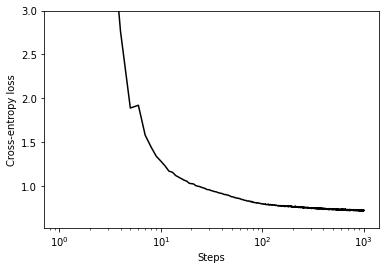

100%|██████████| 1000/1000 [23:58<00:00,  1.44s/it]

Model saved.
Trained on data equivalent to 1000000 solves.


In [19]:
def plot_loss_curve(h):
    fig, ax = plt.subplots(1, 1)
    ax.plot(h)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cross-entropy loss")
    ax.set_xscale("log")
    ax.set_ylim(top=3.) # prevent initial high loss values from dominating the plot
    plt.show()

def train(model, dataloader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=TrainConfig.learning_rate)
    g = iter(dataloader)
    h = []
    for i in trange(1, TrainConfig.num_steps + 1, smoothing=0):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1, 4*4).to(device), batch_y.reshape(-1).to(device)

        if TrainConfig.ENABLE_FP16:
            with torch.cuda.amp.autocast(dtype=torch.float16):
                pred_y = model(batch_x)
                loss = loss_fn(pred_y, batch_y)
        else:
            pred_y = model(batch_x)
        loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if TrainConfig.interval_steps_plot and i % TrainConfig.interval_steps_plot == 0:
            clear_output()
            plot_loss_curve(h)
        if TrainConfig.interval_steps_save and i % TrainConfig.interval_steps_save == 0:
            torch.save(model.state_dict(), f"{i}steps.pth")
            print("Model saved.")
    print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_steps} solves.")
    return model
    
model = train(model, dataloader)

## Inference

We test and compare on the DeepCubeA dataset

In [20]:
%%capture
model.eval()

### Dataset: DeepCubeA

Downloading from GitHub

In [21]:
if "DeepCubeA"!=os.getcwd().split("/")[-1]:
    if not os.path.exists('DeepCubeA'):
        !git clone -q https://github.com/forestagostinelli/DeepCubeA
    %cd ./DeepCubeA/

print('### Optimal Solver ###')
filename = 'data/puzzle15/test/data_0.pkl'
with open(filename, 'rb') as f:
    result_Optimal = pickle.load(f)

    print(result_Optimal.keys())
    result_Optimal["solution_lengths"] = [len(s) for s in result_Optimal["solutions"]]
    result_Optimal["solution_lengths_count"] = {
        i: result_Optimal["solution_lengths"].count(i) 
        for i in range(min(result_Optimal["solution_lengths"]), max(result_Optimal["solution_lengths"]))
    }

    print('No. of cases:', len(result_Optimal["solution_lengths"]))

print('\n### DeepCubeA ###')
filename = 'results/puzzle15/results.pkl'
with open(filename, 'rb') as f:
    result_DeepCubeA = pickle.load(f)

    print(result_DeepCubeA.keys())
    result_DeepCubeA["solution_lengths"] = [len(s) for s in result_DeepCubeA["solutions"]]
    result_DeepCubeA["solution_lengths_count"] = {
        i: result_DeepCubeA["solution_lengths"].count(i) 
        for i in range(min(result_DeepCubeA["solution_lengths"]), max(result_DeepCubeA["solution_lengths"]))
    }

    print('No. of cases:', len(result_DeepCubeA["solution_lengths"]))

%cd ../

/DeepCubeA
### Optimal Solver ###
dict_keys(['solutions', 'states', 'num_nodes_generated', 'times'])
No. of cases: 500

### DeepCubeA ###
dict_keys(['states', 'solutions', 'paths', 'times', 'num_nodes_generated'])
No. of cases: 500
/


In [23]:
#@title Convert optimal solutions to test scrambles
def solution2scramble(solution):
    return [env.pairing[m] for m in solution[::-1]]

test_scrambles = [solution2scramble(s) for s in result_Optimal["solutions"]]

print(f"""Example:\n{result_Optimal["solutions"][0]}\n-> {test_scrambles[0]}""")

Example:
['L', 'L', 'D', 'D', 'R', 'U', 'U', 'R', 'D', 'D', 'R', 'D', 'L', 'L', 'U', 'U', 'L', 'U', 'R', 'D', 'R', 'R', 'D', 'L', 'D', 'L', 'U', 'U', 'R', 'U', 'L', 'D', 'D', 'R', 'U', 'L', 'L', 'U']
-> ['D', 'R', 'R', 'D', 'L', 'U', 'U', 'R', 'D', 'L', 'D', 'D', 'R', 'U', 'R', 'U', 'L', 'L', 'U', 'L', 'D', 'R', 'D', 'D', 'R', 'R', 'U', 'L', 'U', 'U', 'L', 'D', 'D', 'L', 'U', 'U', 'R', 'R']


### Beam Search

In [39]:
def beam_search(
        env,
        model,
        max_depth=SearchConfig.max_depth,
        beam_width=SearchConfig.beam_width,
        skip_redundant_moves=True,
    ):
    """
    Best-first search algorithm.
    Input:
        env: A scrambled instance of the given environment. 
        beam_width: Number of top solutions to return per depth.
        max_depth: Maximum depth of the search tree.
        skip_redundant_moves: If True, skip redundant moves.
        ...
    Output: 
        if solved successfully:
            True, {'solutions':solution path, "num_nodes_generated":number of nodes expanded, "times":time taken to solve}
        else:
            False, None
    """
    with torch.no_grad():
        # metrics
        num_nodes_generated, time_0 = 0, time.time()
        candidates = [
            {"state":deepcopy(env.state), "path":[], "value":1.}
        ] # list of dictionaries

        for depth in range(max_depth+1):
            # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
            batch_x = np.zeros((len(candidates), env.state.shape[-1]), dtype=np.int64)
            for i,c in enumerate(candidates):
                c_path, env.state = c["path"], c["state"]
                if c_path:
                    env.finger(c_path[-1])
                    num_nodes_generated += 1
                    if env.is_solved():
                        return True, {'solutions':c_path, "num_nodes_generated":num_nodes_generated, "times":time.time()-time_0}
                batch_x[i, :] = env.state

            # after checking the nodes expanded at the deepest    
            if depth==max_depth:
                print("Solution not found.")
                return False, None

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x).to("cpu").detach().numpy()
            batch_p = softmax(batch_p, axis=1)

            # loop over candidates
            candidates_next_depth = []  # storage for the depth-level candidates storing (path, value, index).
            for i, c in enumerate(candidates):
                c_path = c["path"]
                value_distribution = batch_p[i, :] # output logits for the given state
                value_distribution *= c["value"] # multiply the cumulative probability so far of the expanded path

                for m, value in zip(env.moves_inference, value_distribution): # iterate over all possible moves.
                    # predicted value to expand the path with the given move.

                    if c_path and skip_redundant_moves:
                        if m not in env.moves_available_after[c_path[-1]]:
                            # Two mutually canceling moves
                            continue
                        elif len(c_path) > 1:
                            if c_path[-2] == c_path[-1] == m:
                                # three subsequent same moves
                                continue
                            elif (
                                c_path[-2][0] == m[0]
                                and len(c_path[-2] + m) == 3
                                and c_path[-1][0] == env.pairing[m[0]]
                            ):
                                # Two mutually canceling moves sandwiching an opposite face move
                                continue

                    # add to the next-depth candidates unless 'continue'd.
                    candidates_next_depth.append({
                        'state':deepcopy(c['state']),
                        "path": c_path+[m],
                        "value":value,
                    })

            # sort potential paths by expected values and renew as 'candidates'
            candidates = sorted(candidates_next_depth, key=lambda item: -item['value'])
            # if the number of candidates exceed that of beam width 'beam_width'
            candidates = candidates[:beam_width]


### Solve

In [40]:
result_ours = {
    "solutions":[],
    "num_nodes_generated":[],
    "times":[]
}
for scramble in tqdm(test_scrambles, position=0):
    # reset and scramble
    env.reset()
    env.apply_scramble(scramble)
    # solve
    success, result = beam_search(env, model)
    if success:
        for k in result_ours.keys():
            result_ours[k].append(result[k])
    else:
        result_ours["solutions"].append(None)

result_ours['solution_lengths'] = [len(e) for e in result_ours['solutions'] if e]
result_ours['solution_lengths_count'] = {
    i: result_ours["solution_lengths"].count(i) 
    for i in range(min(result_ours["solution_lengths"]), max(result_ours["solution_lengths"]))
}
f"Successfully solved {len(result_ours['times'])} cases out of {len(result_ours['solutions'])}"

100%|██████████| 500/500 [37:31<00:00,  4.50s/it]


'Successfully solved 500 cases out of 500'

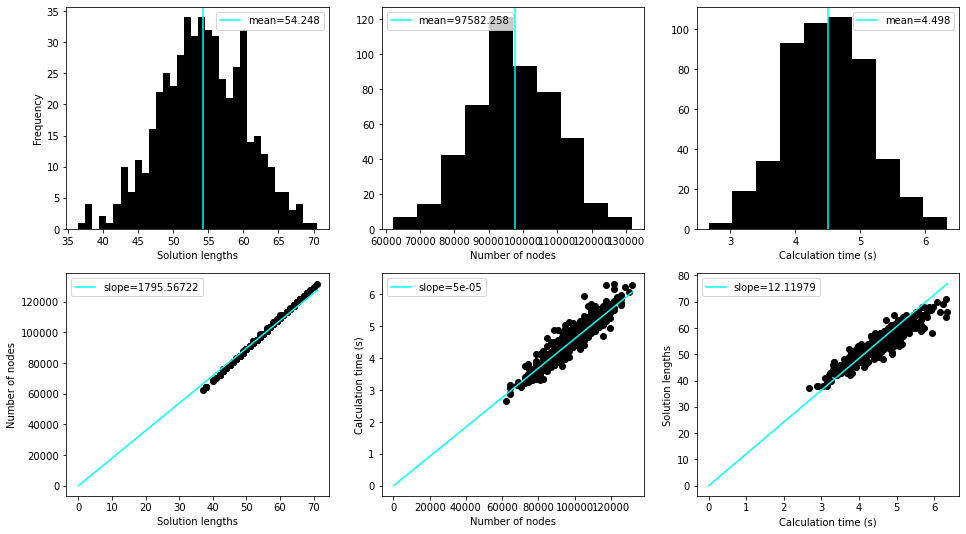

In [41]:
#@title Visualize result
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
ax = ax.ravel()
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Number of nodes")

key_to_text = {
    "solution_lengths": "Solution lengths",
    'num_nodes_generated': "Number of nodes",
    "times":"Calculation time (s)",
}


for i, k in enumerate(["solution_lengths", "num_nodes_generated", "times"]):
    v = result_ours[k]
    if k=="solution_lengths": 
        v_count = result_ours['solution_lengths_count']
        ax[i].bar(
            v_count.keys(), v_count.values(),
            width=1.0,
        )
    else:
        ax[i].hist(v)
    ax[i].axvline(
        np.mean(v),
        color="#00ffff",
        label=f"mean={round(np.mean(v),3)}",
    )
    ax[i].legend()
    ax[i].set_xlabel(key_to_text[k])

for i, (k_x, k_y) in enumerate([("solution_lengths", "num_nodes_generated"), ("num_nodes_generated", "times"), ("times", "solution_lengths")]):
    x, y = [result_ours[k] for k in [k_x, k_y]]
    ax[i+3].set_xlabel(key_to_text[k_x])
    ax[i+3].set_ylabel(key_to_text[k_y])

    coef = np.mean(np.squeeze(np.array(y) / np.array(x)))
    x_range = np.linspace(0, max(x), 100)
    ax[i+3].plot(
        x_range,
        x_range * coef,
        label=f"slope={round(coef, 5)}",
        color="#00ffff",
    )
    ax[i+3].scatter(x, y)
    ax[i+3].legend()

plt.show()

## Comparison to DeepCubeA

### Number of nodes vs. solution length

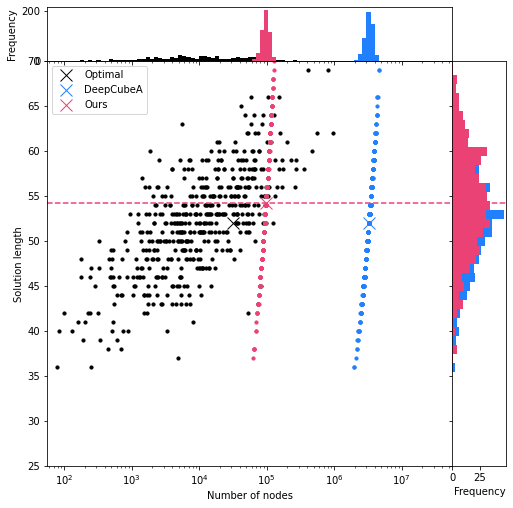

In [42]:
left, width = 0.12, 0.75
bottom, height = 0.1, 0.75
spacing = 0.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height, width, 0.1]
rect_histy = [left + width, bottom, 0.1, height]

fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Solution length")
ax.set_xscale("log")
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_ylim(25, max(result_ours['solution_lengths_count']))
ax_histy.set_ylim(25, max(result_ours['solution_lengths_count']))

xmin, xmax = 1.75, 7.75
ax.set_xlim(10**xmin, 10**xmax)
ax_histx.set_xlim(10**xmin, 10**xmax)
bins_x = np.logspace(xmin, xmax, 100)

################################################################################
k_x, k_y = "num_nodes_generated", "solution_lengths"

for k, d in [("Optimal", result_Optimal), ("DeepCubeA", result_DeepCubeA), ("Ours", result_ours)]:
    x, y = d[k_x], d[k_y]
    ax.scatter(x, y, s=10)
    ax_histx.hist(x, bins=bins_x)

for i, d in enumerate([result_Optimal, result_DeepCubeA, result_ours]):
    d = d["solution_lengths_count"]
    ax_histy.barh(list(d.keys()), list(d.values()), height=1)

ax_histy.axhline(np.mean(result_ours[k_y]), ls="--", color="#EB4275")
ax.axhline(np.mean(result_ours[k_y]), ls="--", color="#EB4275")

ax.plot(np.mean(result_Optimal[k_x]), np.mean(result_Optimal[k_y]), "x", label="Optimal", markersize=12)
ax.plot(np.mean(result_DeepCubeA[k_x]), np.mean(result_DeepCubeA[k_y]), "x", label="DeepCubeA", markersize=12)
ax.plot(np.mean(result_ours[k_x]), np.mean(result_ours[k_y]), "x", label="Ours", markersize=12)
ax.legend()

plt.show()

### Calculation time (s) vs. Solution length

We compare time taken to solve test cases. 

In order to compare fairly our method to DeepCubeA, both of which are DNN-based, we obtain per-node time (s) and adjust ours to DeepCubeA.

Optimal:	0.07 microseconds / node
DeepCubeA:	2.69 microseconds / node
Ours	:	46.09 microseconds / node


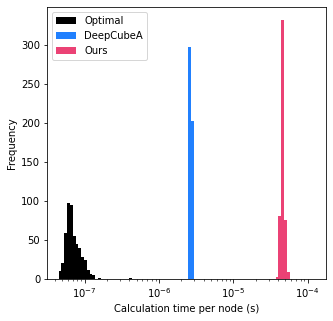

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel("Calculation time per node (s)")
ax.set_ylabel("Frequency")
ax.set_xscale("log")
ax.set_xlim(10**-7.5, 10**-3.75)
bins_x = np.logspace(-7.5, -3.75, 100)

################################################################################

for k, d in [("Optimal", result_Optimal), ("DeepCubeA",result_DeepCubeA), ("Ours",result_ours)]:
    time_per_node = np.array(d["times"])  / np.array(d["num_nodes_generated"])
    ax.hist(time_per_node, bins=bins_x, label=k)
    k = k.replace('Ours','Ours\t')
    print(f"{k}:\t{round(np.mean(time_per_node)*1e6, 2)} microseconds / node")

ax.legend()
plt.show()


In [44]:
t_per_node_DeepCubeA = np.mean(result_DeepCubeA["times"]) / np.mean(result_DeepCubeA["num_nodes_generated"])
t_per_node_Ours = np.mean(result_ours["times"]) / np.mean(result_ours["num_nodes_generated"])
t_ratio = t_per_node_Ours / t_per_node_DeepCubeA
t_ratio

17.121308570342897

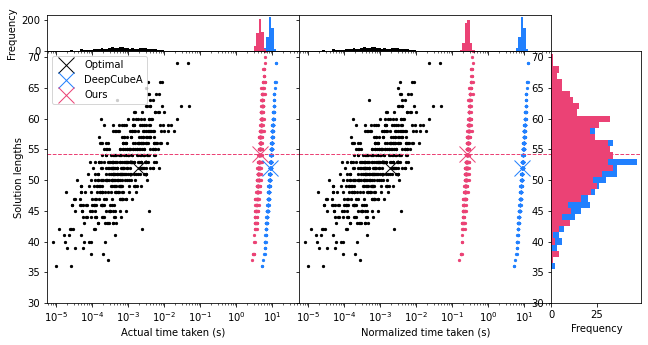

In [45]:
left, width = 0.125, 0.35
bottom, height = 0.135, 0.70

rect_scatter = [left, bottom, width, height]
rect_scatter_j = [left + width, bottom, width, height]
rect_histx_0 = [left, bottom + height, width, 0.10]
rect_histx_1 = [left + width, bottom + height, width, 0.10]
rect_histy = [left + 2 * (width), bottom, 0.125, height]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Actual time taken (s)")
ax.set_ylabel("Solution lengths")
ax.set_xscale("log")
ax_j = fig.add_axes(rect_scatter_j)
ax_j.set_xlabel("Normalized time taken (s)")
ax_j.set_xscale("log")
ax_j.tick_params(axis="y", labelleft=False)

ax_histx_0 = fig.add_axes(rect_histx_0, sharex=ax)
ax_histx_0.set_ylabel("Frequency")
ax_histx_0.tick_params(axis="x", labelbottom=False)
ax_histx_1 = fig.add_axes(rect_histx_1, sharex=ax)
ax_histx_1.tick_params(axis="x", labelbottom=False)
ax_histx_1.tick_params(axis="y", labelleft=False)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histy.set_xlabel("Frequency")
ax_histy.tick_params(axis="y", labelleft=True)

xmin, xmax = -5.25, 1.75
bins_x = np.logspace(xmin, xmax, 100)

################################################################################
k_x, k_y = "times", "solution_lengths"

for k, (t, s) in {
        "Optimal": (result_Optimal[k_x], result_Optimal[k_y]),
        "DeepCubeA": (result_DeepCubeA[k_x], result_DeepCubeA[k_y]),
        "Ours": (result_ours[k_x], result_ours[k_y]),
    }.items():
    ax.scatter(t, s, s=5)
    ax_histx_0.hist(t, bins=bins_x)
    if k == "Ours":
        t_justified = np.array(t) / t_ratio
        ax_histx_1.hist(t_justified, bins=bins_x)
        ax_j.scatter(t_justified, s, label=k, s=5)
    else:
        ax_histx_1.hist(np.array(t), bins=bins_x)
        ax_j.scatter(np.array(t), s, label=k, s=5)

for AX in [ax, ax_j]:
    AX.plot(np.mean(result_Optimal[k_x]), np.mean(result_Optimal[k_y]), "x", label="Optimal", markersize=16)
    AX.plot(np.mean(result_DeepCubeA[k_x]), np.mean(result_DeepCubeA[k_y]), "x", label="DeepCubeA", markersize=16)
    AX.set_xlim(10**xmin, 10**xmax)
    AX.set_ylim(30, max(result_ours["solution_lengths_count"]) + 1)

for AX in [ax, ax_j, ax_histy]:
    AX.axhline(np.mean(result_ours[k_y]), ls="--", lw=1, color="#EB4275")

for i, d in enumerate([result_Optimal, result_DeepCubeA, result_ours]):
    d = d["solution_lengths_count"]
    ax_histy.barh(list(d.keys()), list(d.values()), height=1)

ax.plot(np.mean(result_ours[k_x]), np.mean(result_ours[k_y]), "x", label="Ours", markersize=16)
ax_j.plot(t_per_node_DeepCubeA*np.mean(result_ours["num_nodes_generated"]), np.mean(result_ours[k_y]), "x", markersize=16)

ax.legend(loc="upper left")
plt.show()